### Quasi optics - on-axis calculations of EXCLAIM optics
In this code we estimate analytically the on-axis calculations for the EXCLAIM optics, simulating the mirrors with lenses of equivalent focal length. We will later perform the Fresnel diffraction calculations using PoPPy code.

This block goes utilizes Gaussian optics calculations in Goldsmith (1998) -- see the summary here in the 'Gaussian Beam Optics' section: https://www.overleaf.com/read/gykryddxcnhh

Goal: -40dB at 15deg for primary
-30dB at 15deg for secondary

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import astropy.units as u
from astropy import constants as const
from astropy.units import cds
cds.enable()  

from scipy.special import i0, k0

import copy

figsize = (15,10)
figsize_small=(10,6)

In [2]:
import poppy
from poppy.wfe import WavefrontError
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
poppy.__version__

Populating the interactive namespace from numpy and matplotlib


/opt/anaconda3/envs/main/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['figsize']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


'0.9.1'

EXCLAIM optics parameters (all in cm):

In [3]:
# effective focal lengths of tertiary, secondary, primary
f_1 = 155 * u.cm
f_2 = 11940 * u.cm
f_3 = 19.2 * u.cm

f_lens = 24 * u.cm

# waist at lenslet. From Negar's slides on the lenslet. Output at ~500GHz
# 420GHz: 1.618mm
# 470GHz: 1.616mm
# 480GHz: 1.680mm
# 520GHz: 1.715mm
# 540GHz: 1.708mm

w_0_lenslet = .17 * u.cm 

# CST simulation positions (y,z):
lens_top_position = [-84.67,-51.06] * u.cm
tertiary_position = [-84.67,-18] * u.cm
secondary_position = [0.,0.] * u.cm
primary_position = [-98.67,35.89] * u.cm

d_lenslet_lens = 24 * u.cm
d_lens_3 = ((lens_top_position[0]-tertiary_position[0])**2+(lens_top_position[1]-tertiary_position[1])**2)**.5
d_3_2 = ((secondary_position[0]-tertiary_position[0])**2+(secondary_position[1]-tertiary_position[1])**2)**.5
d_2_1 = ((secondary_position[0]-primary_position[0])**2+(secondary_position[1]-primary_position[1])**2)**.5

d_lens_3 = d_lens_3.to(u.cm)
d_3_2 = d_3_2.to(u.cm)
d_2_1 = d_2_1.to(u.cm)

print("Distances:")
print("\tLenslet-lens: %.3f cm" %d_lenslet_lens.value)
print("\tLens-tertiary: %.3f cm" %d_lens_3.value)
print("\tTertiary-secondary: %.3f cm" %d_3_2.value)
print("\tSecondary-primary: %.3f cm" %d_2_1.value)

waist_3 = 17.53021265771928*u.cm

Distances:
	Lenslet-lens: 24.000 cm
	Lens-tertiary: 33.060 cm
	Tertiary-secondary: 86.562 cm
	Secondary-primary: 104.995 cm


In [4]:
ff = 480*u.GHz#500*u.GHz
ll = const.c/ff

# Poppy calculations

In [5]:
plot_widths = False
width_array = [] # append for each step_dist for plot of width sizes
step_dist = 0.01 * u.cm

## Initialize objects for optical elements

# Waist at lens, initialize Gaussian w/ FWHM=waist

In [6]:
#class phase_gradient(WavefrontError): # Option A
class phase_gradient(poppy.AnalyticOpticalElement): # Option B - from POPPY documentation
    def __init__(self,x_center_offset,d_z,freq, **kwargs):
        #super(WavefrontError, self).__init__(name='Phase Gradient', **kwargs) # Option A
        poppy.AnalyticOpticalElement.__init__(self,**kwargs) # Option B - from POPPY documentation
        
        self.x_center_offset=x_center_offset
        self.d_z=d_z
        self.freq=freq
    
    def get_opd(self, wave):
        """
        Parameters
        ----------
        wave : poppy.Wavefront (or float)
            Incoming Wavefront before this optic to set wavelength and
            scale, or a float giving the wavelength in meters
            for a temporary Wavefront used to compute the OPD.
        """

        y, x = self.get_coordinates(wave)*u.m#*u.cm  # in meters
        k = (2*np.pi*self.freq/const.c).to(1./u.m)

        opd = -((x.to(u.m)+self.x_center_offset.to(u.m))**2/(2*self.d_z.to(u.m))).to(u.m)
        
        return opd.value
    
    # behind the scenes poppy  will calculate:
    # phasor = transmission = np.exp(1.j * 2 * np.pi / wave.wavelength * opd)

In [7]:
fwhm_ = np.sqrt(np.log(2)/297.4178) * u.m
w_lens = 2.71*u.cm
cold_stop_radius = 0.0381*u.m

lens_aperture = poppy.GaussianAperture(fwhm=fwhm_)
lens_obj = poppy.QuadraticLens(f_lens)
tertiary_obj = poppy.QuadraticLens(f_3)
secondary_obj = poppy.QuadraticLens(f_2)
primary_obj = poppy.QuadraticLens(f_1)

ring = poppy.CircularAperture(radius=cold_stop_radius)

In [8]:
baffle_spacing = 0.00064*u.m
baffle = poppy.CircularAperture(radius=(cold_stop_radius + baffle_spacing))

# all in inches
baffle_z_array = [0.350,
        0.700,
        1.050,
        2.150,
        2.500,
        2.850,
        3.950,
        4.300,
        4.650]

for i,baffle_z in enumerate(baffle_z_array):
    baffle_z_array[i] = (baffle_z*u.cds.inch).to(u.cm)

In [9]:
baffle_IF_rad = 4*u.cm
baffle_IF = poppy.CircularAperture(radius=baffle_IF_rad)

After aperture, beam waist is at 0.0 m


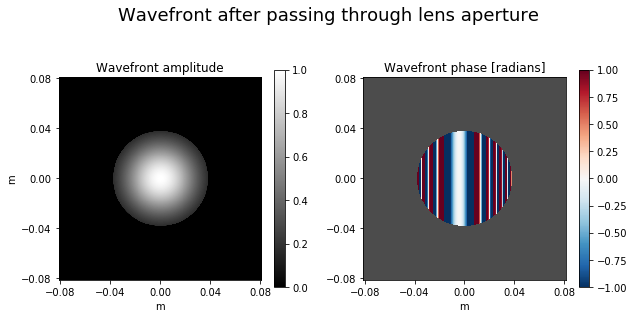

In [10]:
w_extent = 3

wf = poppy.FresnelWavefront(beam_radius=w_lens*w_extent, wavelength=ll)#,npix=4096)

wf *= lens_aperture
wf *= ring # cold stop
wf *= phase_gradient(4.5*u.mm,d_lenslet_lens,ff.to(u.GHz))

print("After aperture, beam waist is at {}".format(wf.z_w0) )

plt.figure(figsize=(10,5))
wf.display('both', colorbar=True);
plt.suptitle("Wavefront after passing through lens aperture", fontsize=18);

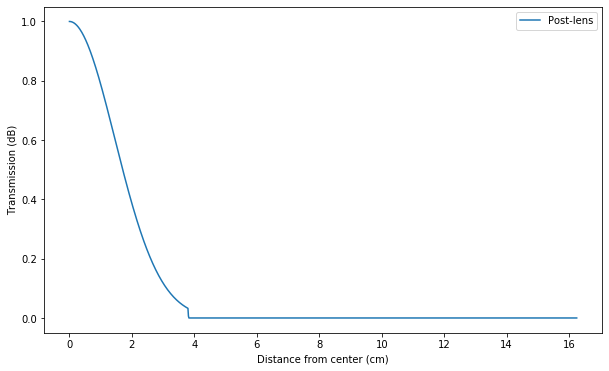

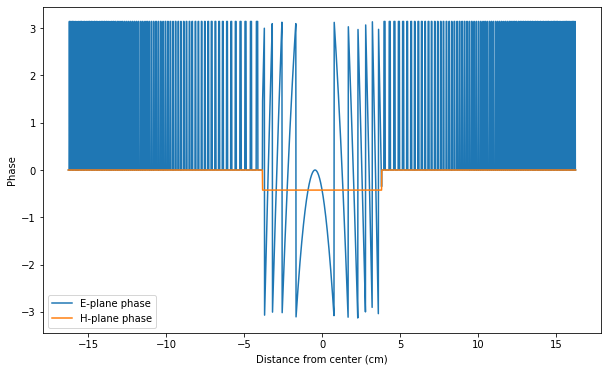

/opt/anaconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in true_divide
/opt/anaconda3/envs/main/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


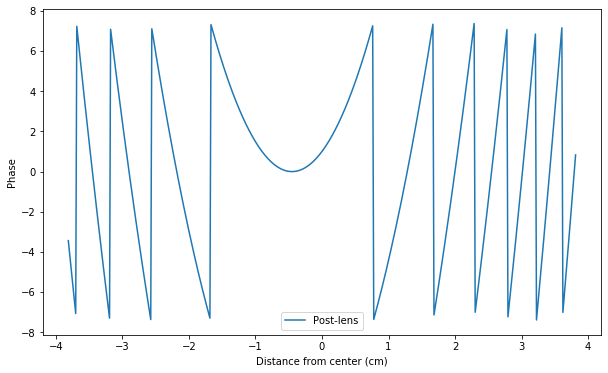

In [11]:
y_lens, x_lens = wf.coordinates()
z_lens = wf.intensity
z_phase_lens = wf.phase
array_length = z_lens.shape[0]
half_array_length = int(z_lens.shape[0]/2)

fig = plt.figure(figsize=figsize_small)
plt.plot(x_lens[half_array_length,half_array_length:]*100,(z_lens[half_array_length,half_array_length:]),
         label='Post-lens')
plt.xlabel('Distance from center (cm)')
plt.ylabel('Transmission (dB)')
#plt.yscale('log')
plt.legend()
plt.show()

fig = plt.figure(figsize=figsize_small)
plt.plot(x_lens[half_array_length]*100,z_phase_lens[half_array_length],
         label='E-plane phase')
plt.plot(x_lens[half_array_length]*100,z_phase_lens[:,half_array_length],
         label='H-plane phase')
plt.xlabel('Distance from center (cm)')
plt.ylabel('Phase')
#plt.yscale('log')
plt.legend()
plt.show()

fig = plt.figure(figsize=figsize_small)
plt.plot(x_lens[half_array_length]*100,z_phase_lens[half_array_length]/z_phase_lens[:,half_array_length],
         label='Post-lens')
plt.xlabel('Distance from center (cm)')
plt.ylabel('Phase')
#plt.yscale('log')
plt.legend()
plt.show()

In [12]:
if plot_widths:
    for mm in range(int(round(d_lens_3.value,2)/step_dist.value)):
        if mm%100==0:
            print(mm*step_dist)
        wf.propagate_fresnel(step_dist)
        width_array.append(wf.spot_radius().to(u.cm))
else:
    wf_b = copy.deepcopy(wf)
    
    # wf no baffles:
    wf.propagate_fresnel(d_lens_3)
    
    # wf w/ baffles
    baffle_distance_sum = 0
    for i,baffle_z in enumerate(baffle_z_array):
        if i==0:
            wf_b.propagate_fresnel(baffle_z)
        else:
            wf_b.propagate_fresnel(baffle_z-baffle_z_array[i-1])
        wf_b*=baffle
        
    wf_b.propagate_fresnel(d_lens_3-baffle_z_array[-1])
    
    z_3_b = wf_b.intensity
    
    y_3_b,x_3_b = wf_b.coordinates()

y_3, x_3 = wf.coordinates()
z_3 = wf.intensity

array_length = z_3.shape[0]
half_array_length = int(z_3.shape[0]/2)

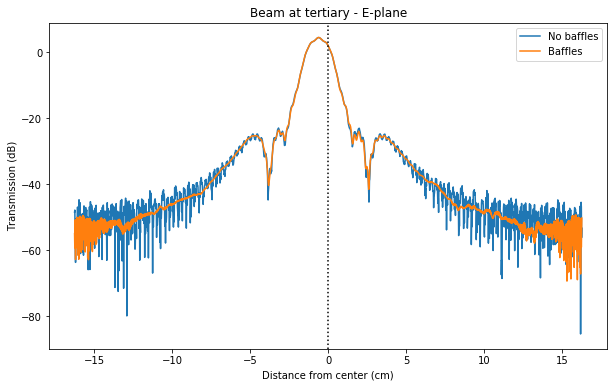

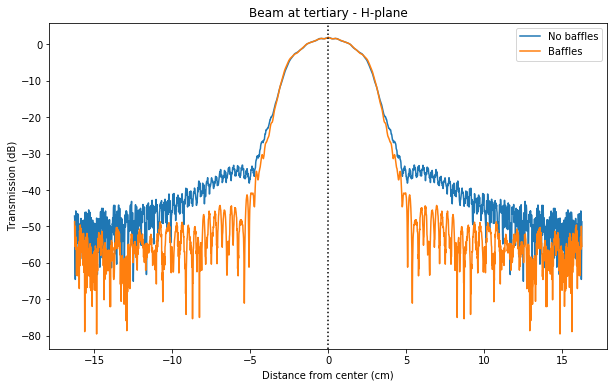

"\nfig2 = plt.figure(figsize=figsize_small)\nplt.plot(x_3[half_array_length,:]*100,\n         10*np.log10(z_3[half_array_length,:]),\n         label='No baffles')\nif not plot_widths:\n    plt.plot(x_3_b[half_array_length,:]*100,\n             10*np.log10(z_3_b[half_array_length,:]),\n             label='Baffles')\n    \nplt.axvline(x=0,color='black',linestyle=':')\nplt.xlabel('Distance from center (cm)')\nplt.ylabel('Transmission (dB)')\nplt.title('Beam at tertiary - E-plane')\nplt.legend()\nplt.show()\n\nfig2 = plt.figure(figsize=figsize_small)\nplt.plot(x_3[half_array_length,:]*100,\n         10*np.log10(z_3[:,half_array_length])-10*np.log10(z_3[half_array_length,:]),\n         label='No baffles')\nif not plot_widths:\n    plt.plot(x_3_b[half_array_length,:]*100,\n             10*np.log10(z_3_b[:,half_array_length])-10*np.log10(z_3_b[half_array_length,:]),\n             label='Baffles')\n    \nplt.axvline(x=0,color='black',linestyle=':')\nplt.xlabel('Distance from center (cm)')\nplt

In [13]:
fig2 = plt.figure(figsize=figsize_small)
plt.plot(x_3[half_array_length,:]*100,
         10*np.log10(z_3[half_array_length,:]),
         label='No baffles')
if not plot_widths:
    plt.plot(x_3_b[half_array_length,:]*100,
             10*np.log10(z_3_b[half_array_length,:]),
             label='Baffles')
    
plt.axvline(x=0,color='black',linestyle=':')
plt.xlabel('Distance from center (cm)')
plt.ylabel('Transmission (dB)')
plt.title('Beam at tertiary - E-plane')
plt.legend()
plt.show()

fig2 = plt.figure(figsize=figsize_small)
plt.plot(x_3[half_array_length,:]*100,
         10*np.log10(z_3[:,half_array_length]),
         label='No baffles')
if not plot_widths:
    plt.plot(x_3_b[half_array_length,:]*100,
             10*np.log10(z_3_b[:,half_array_length]),
             label='Baffles')
    
plt.axvline(x=0,color='black',linestyle=':')
plt.xlabel('Distance from center (cm)')
plt.ylabel('Transmission (dB)')
plt.title('Beam at tertiary - H-plane')
plt.legend()
plt.show()

"""
fig2 = plt.figure(figsize=figsize_small)
plt.plot(x_3[half_array_length,:]*100,
         10*np.log10(z_3[half_array_length,:]),
         label='No baffles')
if not plot_widths:
    plt.plot(x_3_b[half_array_length,:]*100,
             10*np.log10(z_3_b[half_array_length,:]),
             label='Baffles')
    
plt.axvline(x=0,color='black',linestyle=':')
plt.xlabel('Distance from center (cm)')
plt.ylabel('Transmission (dB)')
plt.title('Beam at tertiary - E-plane')
plt.legend()
plt.show()

fig2 = plt.figure(figsize=figsize_small)
plt.plot(x_3[half_array_length,:]*100,
         10*np.log10(z_3[:,half_array_length])-10*np.log10(z_3[half_array_length,:]),
         label='No baffles')
if not plot_widths:
    plt.plot(x_3_b[half_array_length,:]*100,
             10*np.log10(z_3_b[:,half_array_length])-10*np.log10(z_3_b[half_array_length,:]),
             label='Baffles')
    
plt.axvline(x=0,color='black',linestyle=':')
plt.xlabel('Distance from center (cm)')
plt.ylabel('Transmission (dB)')
plt.title('Beam at tertiary - E-plane / H-plane')
plt.legend()
plt.show()"""

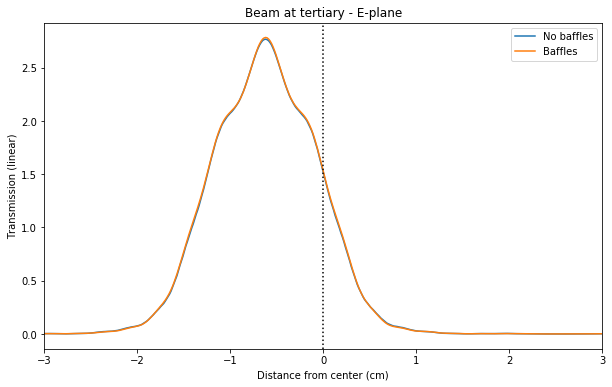

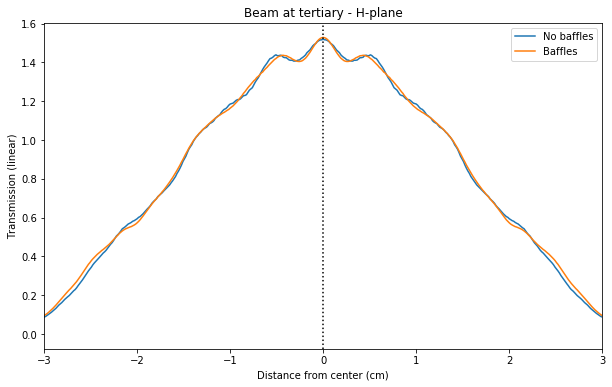

1024
985
-0.0061927734375
-1.0731345731478033 rad


In [14]:
fig2 = plt.figure(figsize=figsize_small)
plt.plot(x_3[half_array_length,:]*100,
         (z_3[half_array_length,:]),
         label='No baffles')
if not plot_widths:
    plt.plot(x_3_b[half_array_length,:]*100,
             (z_3_b[half_array_length,:]),
             label='Baffles')
    
plt.axvline(x=0,color='black',linestyle=':')
plt.xlim((-3,3))
plt.xlabel('Distance from center (cm)')
plt.ylabel('Transmission (linear)')
plt.title('Beam at tertiary - E-plane')
plt.legend()
plt.show()

fig2 = plt.figure(figsize=figsize_small)
plt.plot(x_3[half_array_length,:]*100,
         (z_3[:,half_array_length]),
         label='No baffles')
if not plot_widths:
    plt.plot(x_3_b[half_array_length,:]*100,
             (z_3_b[:,half_array_length]),
             label='Baffles')
    
plt.axvline(x=0,color='black',linestyle=':')
plt.xlim((-3,3))
plt.xlabel('Distance from center (cm)')
plt.ylabel('Transmission (linear)')
plt.title('Beam at tertiary - H-plane')
plt.legend()
plt.show()

arg_max = np.argmax(z_3[half_array_length,:])
#arg_max = half_array_length+1
print(half_array_length)
print(arg_max)
x_max = x_3[half_array_length,arg_max]
print(x_max)
print(np.arctan((x_max*u.m / d_lens_3).to(1))*180/np.pi)

In [15]:
wf*=tertiary_obj

if not plot_widths:
    wf_b*=tertiary_obj
    
waist_post_tertiary = wf.z_w0-d_lens_3

waist_3 = waist_post_tertiary
print(waist_post_tertiary)

0.19199359822615158 m


In [16]:
if plot_widths:
    for mm in range(int(round(d_3_2.value,2)/step_dist.value)):
        if mm%100==0:
            print(mm*step_dist)
        wf.propagate_fresnel(step_dist)
        width_array.append(wf.spot_radius().to(u.cm))
else:
    wf_0_b = copy.deepcopy(wf)
    wf_b_b = copy.deepcopy(wf_b)
    
    wf.propagate_fresnel(d_3_2)
    wf_b.propagate_fresnel(d_3_2)
    #wf_0_b.propagate_fresnel(d_3_2)
    #wf_b_b.propagate_fresnel(d_3_2)
    
    wf_0_b.propagate_fresnel(waist_3)
    wf_0_b*=baffle_IF
    wf_0_b.propagate_fresnel(d_3_2-waist_3)
    
    wf_b_b.propagate_fresnel(waist_3)
    wf_b_b*=baffle_IF
    wf_b_b.propagate_fresnel(d_3_2-waist_3)
    
    z_2_b = wf_b.intensity
    z_2_0_b = wf_0_b.intensity
    z_2_b_b = wf_b_b.intensity
    
    y_2_b,x_2_b = wf_b.coordinates()
    y_2_0_b,x_2_0_b = wf_0_b.coordinates()
    y_2_b_b,x_2_b_b = wf_b_b.coordinates()
    
    d_waist = (d_3_2.to(u.m) - waist_3.to(u.m))
    plot_angle_array_b = np.arctan(np.array(x_2_b[half_array_length,:]/d_waist.value))*180/np.pi
    plot_angle_array_0_b = np.arctan(np.array(x_2_0_b[half_array_length,:]/d_waist.value))*180/np.pi
    plot_angle_array_b_b = np.arctan(np.array(x_2_b_b[half_array_length,:]/d_waist.value))*180/np.pi

y_2, x_2 = wf.coordinates()
z_2 = wf.intensity
array_length = z_2.shape[0]
half_array_length = int(z_2.shape[0]/2)

if z_2.shape!=z_2_b.shape or z_2.shape!=z_2_0_b.shape or z_2.shape!=z_2_b_b.shape:
    print("Warning: shapes don't match!")

plot_angle_array = np.arctan(np.array(x_2[half_array_length,:])/d_waist.value)*180/np.pi

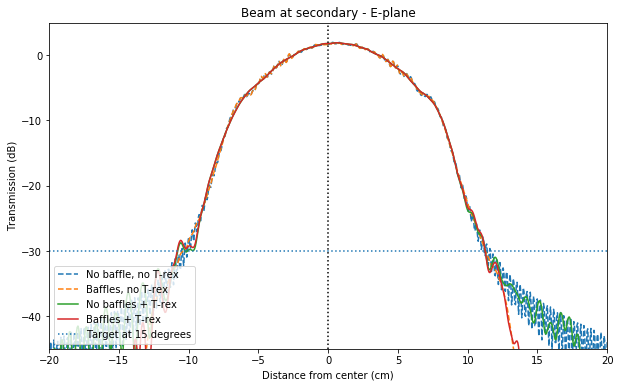

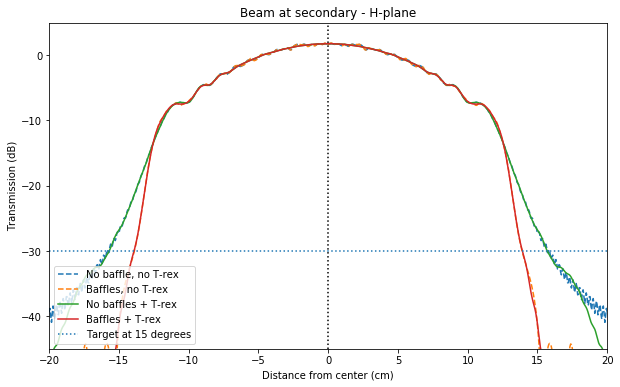

In [17]:
fig3 = plt.figure(figsize=figsize_small)
plt.plot(x_2[half_array_length,:]*100,10*np.log10(z_2[half_array_length,:]),
         label='No baffle, no T-rex',linestyle='--')
if not plot_widths:
    plt.plot(x_2_b[half_array_length,:]*100,10*np.log10(z_2_b[half_array_length,:]),
             label='Baffles, no T-rex',linestyle='--')
    plt.plot(x_2_0_b[half_array_length,:]*100,10*np.log10(z_2_0_b[half_array_length,:]),
             label='No baffles + T-rex')
    plt.plot(x_2_b_b[half_array_length,:]*100,10*np.log10(z_2_b_b[half_array_length,:]),
             label='Baffles + T-rex')
plt.axhline(y=-30,label='Target at 15 degrees',linestyle=':')

plt.axvline(x=0,color='black',linestyle=':')
plt.xlim((-20,20))
plt.ylim((-45,5))
#plt.xlabel('Angle (deg)')
plt.xlabel('Distance from center (cm)')
plt.ylabel('Transmission (dB)')
plt.title('Beam at secondary - E-plane')
#plt.yscale('log')
plt.legend(loc='lower left')
plt.show()

fig3 = plt.figure(figsize=figsize_small)
plt.plot(x_2[half_array_length,:]*100,10*np.log10(z_2[:,half_array_length]),
         label='No baffle, no T-rex',linestyle='--')
if not plot_widths:
    plt.plot(x_2_b[half_array_length,:]*100,10*np.log10(z_2_b[:,half_array_length]),
             label='Baffles, no T-rex',linestyle='--')
    plt.plot(x_2_0_b[half_array_length,:]*100,10*np.log10(z_2_0_b[:,half_array_length]),
             label='No baffles + T-rex')
    plt.plot(x_2_b_b[half_array_length,:]*100,10*np.log10(z_2_b_b[:,half_array_length]),
             label='Baffles + T-rex')
plt.axhline(y=-30,label='Target at 15 degrees',linestyle=':')

plt.axvline(x=0,color='black',linestyle=':')
plt.xlim((-20,20))
plt.ylim((-45,5))
#plt.xlabel('Angle (deg)')
plt.xlabel('Distance from center (cm)')
plt.ylabel('Transmission (dB)')
plt.title('Beam at secondary - H-plane')
#plt.yscale('log')
plt.legend(loc='lower left')
plt.show()

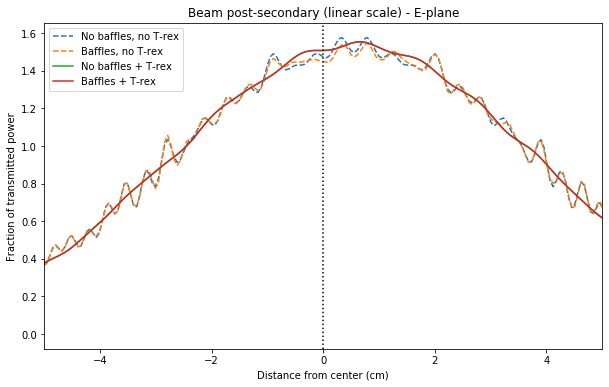

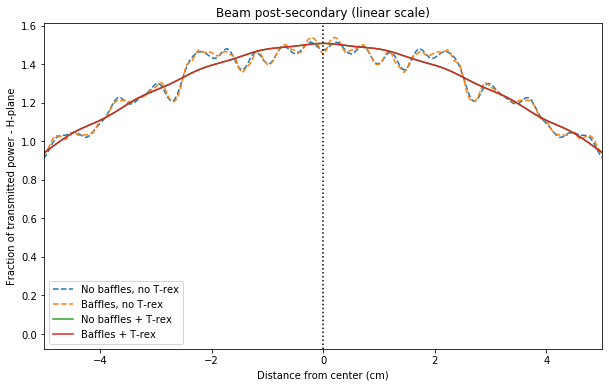

In [18]:
fig3 = plt.figure(figsize=figsize_small)
plt.plot(x_2[half_array_length,:]*100,(z_2[half_array_length,:]),
         label='No baffles, no T-rex',linestyle='--')
if not plot_widths:
    plt.plot(x_2_b[half_array_length,:]*100,(z_2_b[half_array_length,:]),
         label='Baffles, no T-rex',linestyle='--')
    plt.plot(x_2_0_b[half_array_length,:]*100,(z_2_0_b[half_array_length,:]),
         label='No baffles + T-rex')
    plt.plot(x_2_b_b[half_array_length,:]*100,(z_2_b_b[half_array_length,:]),
         label='Baffles + T-rex')

plt.axvline(x=0,color='black',linestyle=':')
#plt.xlabel('Angle (deg)')
plt.xlabel('Distance from center (cm)')
plt.ylabel('Fraction of transmitted power')
plt.xlim((-5,5))
#plt.ylim((-60,5))
#plt.yscale('log')
plt.title('Beam post-secondary (linear scale) - E-plane')
plt.legend()
plt.show()

fig3 = plt.figure(figsize=figsize_small)
plt.plot(x_2[half_array_length,:]*100,(z_2[:,half_array_length]),
         label='No baffles, no T-rex',linestyle='--')
if not plot_widths:
    plt.plot(x_2_b[half_array_length,:]*100,(z_2_b[:,half_array_length]),
         label='Baffles, no T-rex',linestyle='--')
    plt.plot(x_2_0_b[half_array_length,:]*100,(z_2_0_b[:,half_array_length]),
         label='No baffles + T-rex')
    plt.plot(x_2_b_b[half_array_length,:]*100,(z_2_b_b[:,half_array_length]),
         label='Baffles + T-rex')

plt.axvline(x=0,color='black',linestyle=':')
#plt.xlabel('Angle (deg)')
plt.xlabel('Distance from center (cm)')
plt.ylabel('Fraction of transmitted power - H-plane')
plt.xlim((-5,5))
#plt.ylim((-60,5))
#plt.yscale('log')
plt.title('Beam post-secondary (linear scale)')
plt.legend()
plt.show()

In [19]:
wf*=secondary_obj
if not plot_widths:
    wf_b*=secondary_obj
    wf_0_b*=secondary_obj
    wf_b_b*=secondary_obj

In [20]:
if plot_widths:
    for mm in range(int(round(d_2_1.value,2)/step_dist.value)):
        if mm%100==0:
            print(mm*step_dist)
        wf.propagate_fresnel(step_dist)
        width_array.append(wf.spot_radius().to(u.cm))
else:
    wf.propagate_fresnel(d_2_1)
    wf_b.propagate_fresnel(d_2_1)
    wf_0_b.propagate_fresnel(d_2_1)
    wf_b_b.propagate_fresnel(d_2_1)
    
    z_1_b = wf_b.intensity
    z_1_0_b = wf_0_b.intensity
    z_1_b_b = wf_b_b.intensity
    
    y_1_b,x_1_b = wf_b.coordinates()
    y_1_0_b,x_1_0_b = wf_0_b.coordinates()
    y_1_b_b,x_1_b_b = wf_b_b.coordinates()
    
    d_waist = d_3_2.to(u.m) + d_2_1.to(u.m) - waist_3.to(u.m)
    plot_angle_array_b = np.arctan(np.array(x_1_b[half_array_length,:]/d_waist.value))*180/np.pi
    plot_angle_array_0_b = np.arctan(np.array(x_1_0_b[half_array_length,:]/d_waist.value))*180/np.pi
    plot_angle_array_b_b = np.arctan(np.array(x_1_b_b[half_array_length,:]/d_waist.value))*180/np.pi
    
y_1, x_1 = wf.coordinates()
z_1 = wf.intensity
array_length = z_1.shape[0]
half_array_length = int(z_1.shape[0]/2)

d_waist = d_3_2.to(u.m) + d_2_1.to(u.m) - waist_3.to(u.m)
print(d_waist)
print(x_1[half_array_length,half_array_length:])

plot_angle_array = np.arctan(np.array(x_1[half_array_length,:]/d_waist.value))*180/np.pi

1.7235738406106718 m
[0.00000000e+00 1.42058945e-03 2.84117890e-03 ... 1.45042183e+00
 1.45184242e+00 1.45326301e+00]


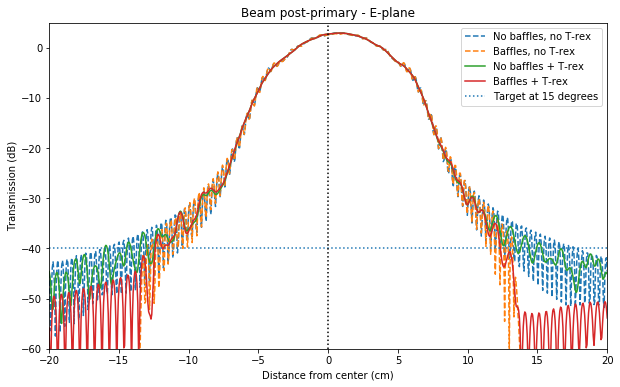

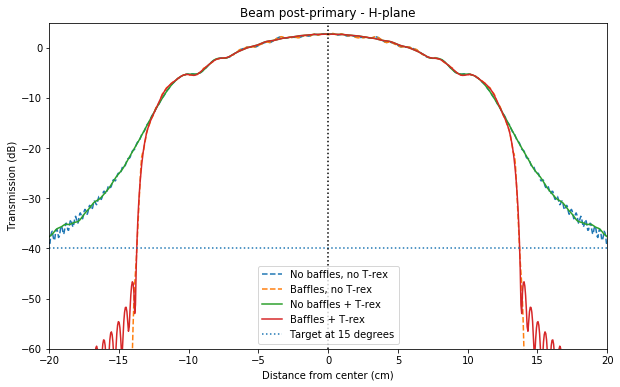

In [21]:
fig3 = plt.figure(figsize=figsize_small)
plt.plot(x_2[half_array_length,:]*100,10*np.log10(z_1[half_array_length,:]),
         label='No baffles, no T-rex',linestyle='--')
if not plot_widths:
    plt.plot(x_2_b[half_array_length,:]*100,10*np.log10(z_1_b[half_array_length,:]),
         label='Baffles, no T-rex',linestyle='--')
    plt.plot(x_2_0_b[half_array_length,:]*100,10*np.log10(z_1_0_b[half_array_length,:]),
         label='No baffles + T-rex')
    plt.plot(x_2_b_b[half_array_length,:]*100,10*np.log10(z_1_b_b[half_array_length,:]),
         label='Baffles + T-rex')
plt.axhline(y=-40,label='Target at 15 degrees',linestyle=':')

plt.axvline(x=0,color='black',linestyle=':')
#plt.xlabel('Angle (deg)')
plt.xlabel('Distance from center (cm)')
plt.ylabel('Transmission (dB)')
plt.xlim((-20,20))
plt.ylim((-60,5))
#plt.yscale('log')
plt.title('Beam post-primary - E-plane')
plt.legend()
plt.show()

fig3 = plt.figure(figsize=figsize_small)
plt.plot(x_2[half_array_length,:]*100,10*np.log10(z_1[:,half_array_length]),
         label='No baffles, no T-rex',linestyle='--')
if not plot_widths:
    plt.plot(x_2_b[half_array_length,:]*100,10*np.log10(z_1_b[:,half_array_length]),
         label='Baffles, no T-rex',linestyle='--')
    plt.plot(x_2_0_b[half_array_length,:]*100,10*np.log10(z_1_0_b[:,half_array_length]),
         label='No baffles + T-rex')
    plt.plot(x_2_b_b[half_array_length,:]*100,10*np.log10(z_1_b_b[:,half_array_length]),
         label='Baffles + T-rex')
plt.axhline(y=-40,label='Target at 15 degrees',linestyle=':')

plt.axvline(x=0,color='black',linestyle=':')
#plt.xlabel('Angle (deg)')
plt.xlabel('Distance from center (cm)')
plt.ylabel('Transmission (dB)')
plt.xlim((-20,20))
plt.ylim((-60,5))
#plt.yscale('log')
plt.title('Beam post-primary - H-plane')
plt.legend()
plt.show()

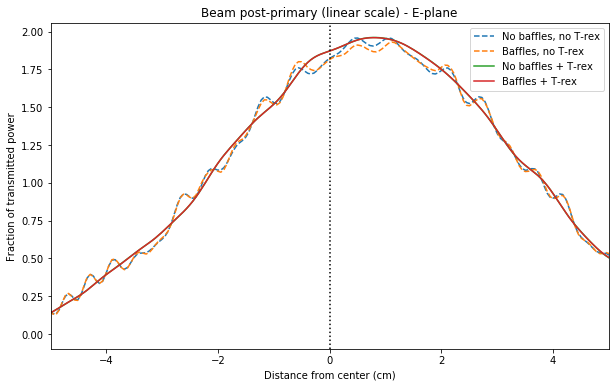

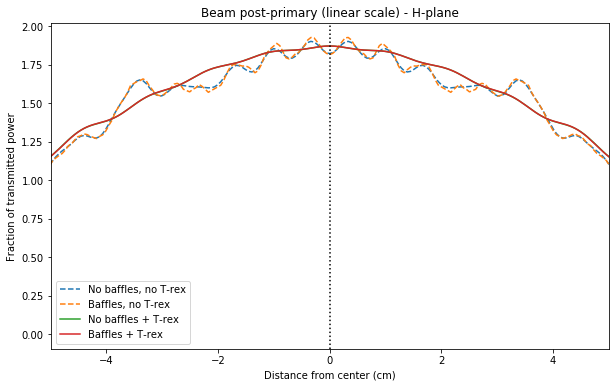

In [22]:
fig3 = plt.figure(figsize=figsize_small)
plt.plot(x_2[half_array_length,:]*100,(z_1[half_array_length,:]),
         label='No baffles, no T-rex',linestyle='--')
if not plot_widths:
    plt.plot(x_2_b[half_array_length,:]*100,(z_1_b[half_array_length,:]),
         label='Baffles, no T-rex',linestyle='--')
    plt.plot(x_2_0_b[half_array_length,:]*100,(z_1_0_b[half_array_length,:]),
         label='No baffles + T-rex')
    plt.plot(x_2_b_b[half_array_length,:]*100,(z_1_b_b[half_array_length,:]),
         label='Baffles + T-rex')

plt.axvline(x=0,color='black',linestyle=':')
#plt.xlabel('Angle (deg)')
plt.xlabel('Distance from center (cm)')
plt.ylabel('Fraction of transmitted power')
plt.xlim((-5,5))
#plt.ylim((-60,5))
#plt.yscale('log')
plt.title('Beam post-primary (linear scale) - E-plane')
plt.legend()
plt.show()

fig3 = plt.figure(figsize=figsize_small)
plt.plot(x_2[half_array_length,:]*100,(z_1[:,half_array_length]),
         label='No baffles, no T-rex',linestyle='--')
if not plot_widths:
    plt.plot(x_2_b[half_array_length,:]*100,(z_1_b[:,half_array_length]),
         label='Baffles, no T-rex',linestyle='--')
    plt.plot(x_2_0_b[half_array_length,:]*100,(z_1_0_b[:,half_array_length]),
         label='No baffles + T-rex')
    plt.plot(x_2_b_b[half_array_length,:]*100,(z_1_b_b[:,half_array_length]),
         label='Baffles + T-rex')

plt.axvline(x=0,color='black',linestyle=':')
#plt.xlabel('Angle (deg)')
plt.xlabel('Distance from center (cm)')
plt.ylabel('Fraction of transmitted power')
plt.xlim((-5,5))
#plt.ylim((-60,5))
#plt.yscale('log')
plt.title('Beam post-primary (linear scale) - H-plane')
plt.legend()
plt.show()

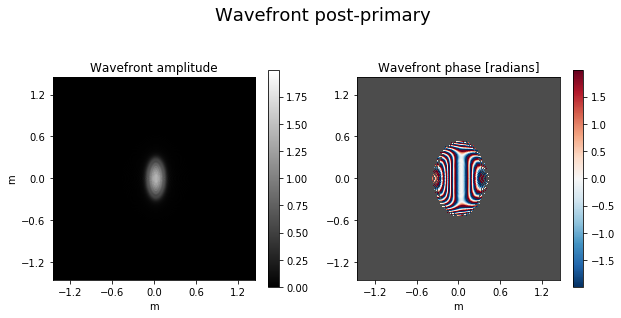

In [23]:
wf*=primary_obj

plt.figure(figsize=(10,5))
wf.display('both', colorbar=True)
plt.suptitle("Wavefront post-primary", fontsize=18);

101.72357384061067 m
[0.00000000e+00 7.99189007e-03 1.59837801e-02 ... 8.15971976e+00
 8.16771165e+00 8.17570354e+00]


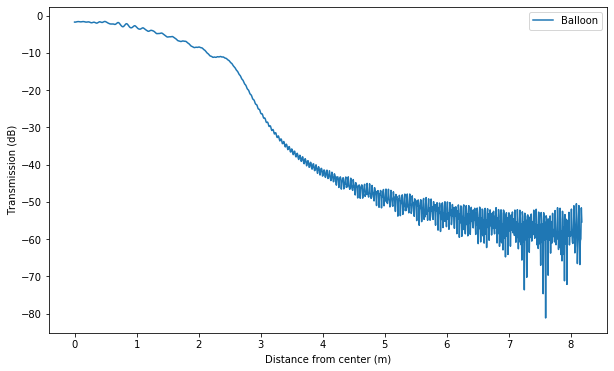

In [24]:
wf.propagate_fresnel(100*u.m)

y_0, x_0 = wf.coordinates()
z_0 = wf.intensity
array_length = z_0.shape[0]
half_array_length = int(z_0.shape[0]/2)

d_waist = 100*u.m + d_3_2.to(u.m) + d_2_1.to(u.m) - waist_3.to(u.m)
print(d_waist)
print(x_0[half_array_length,half_array_length:])

plot_angle_array = np.arctan(np.array(x_0[half_array_length,half_array_length:]/d_waist.value))*180/np.pi

fig3 = plt.figure(figsize=figsize_small)
plt.plot(x_0[half_array_length,half_array_length:],10*np.log10(z_0[half_array_length,half_array_length:]),
         label='Balloon')
#plt.xlabel('Distance from center (cm)')
#plt.xlabel('Angle (deg)')
plt.xlabel('Distance from center (m)')
plt.ylabel('Transmission (dB)')
#plt.xlim((-15,15))
#plt.yscale('log')
plt.legend()
plt.show()

101.72357384061067 m
[0.00000000e+00 7.99189007e-03 1.59837801e-02 ... 8.15971976e+00
 8.16771165e+00 8.17570354e+00]


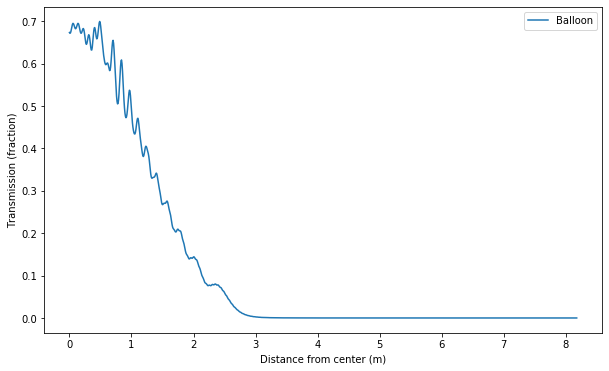

In [25]:
y_0, x_0 = wf.coordinates()
z_0 = wf.intensity
array_length = z_0.shape[0]
half_array_length = int(z_0.shape[0]/2)

d_waist = 100*u.m + d_3_2.to(u.m) + d_2_1.to(u.m) - waist_3.to(u.m)
print(d_waist)
print(x_0[half_array_length,half_array_length:])

plot_angle_array = np.arctan(np.array(x_0[half_array_length,half_array_length:]/d_waist.value))*180/np.pi

fig3 = plt.figure(figsize=figsize_small)
plt.plot(x_0[half_array_length,half_array_length:],(z_0[half_array_length,half_array_length:]),
         label='Balloon')
#plt.xlabel('Distance from center (cm)')
#plt.xlabel('Angle (deg)')
plt.xlabel('Distance from center (m)')
plt.ylabel('Transmission (fraction)')
#plt.xlim((-15,15))
#plt.yscale('log')
plt.legend()
plt.show()

Distances:
	Lens-tertiary: 33.060 cm
	Lens-secondary: 119.622 cm
	Lens-primary: 224.617 cm


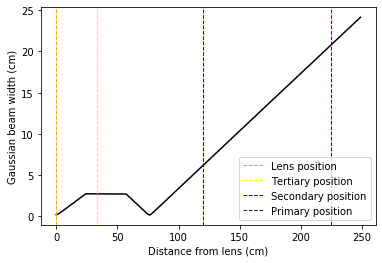

In [26]:
#plot_widths=True
if not plot_widths:
    width_array = np.loadtxt('no_baffle_width_array.txt')
distance_array = np.linspace(0,len(width_array)/100,len(width_array))

d_lens_3 = d_lens_3
d_lens_2 = d_lens_3 + d_3_2
d_lens_1 = d_lens_2 + d_2_1

print("Distances:")
print("\tLens-tertiary: %.3f cm" %d_lens_3.value)
print("\tLens-secondary: %.3f cm" %d_lens_2.value)
print("\tLens-primary: %.3f cm" %d_lens_1.value)

for i,width in enumerate(width_array):
    width_array[i] = width #.value

#plt.figure(figsize=(10,6))
plt.figure(figsize=(6,4))
plt.plot(distance_array,width_array,color='black')
plt.xlabel('Distance from lens (cm)')
plt.ylabel('Gaussian beam width (cm)')
plt.axvline(x=0,linewidth=1, color='orange',linestyle='--',label='Lens position')
plt.axvline(x=(d_lens_3).value,linewidth=1, color='yellow',linestyle='--',label='Tertiary position')
plt.axvline(x=(d_lens_2).value,linewidth=1, color='blue',linestyle='--',label='Secondary position')
plt.axvline(x=(d_lens_1).value,linewidth=1, color='indigo',linestyle='--',label='Primary position')
plt.legend()
plt.show()

#### 